# Supernovae_MCMC

Run Monte Carlo Markov Chains using the Metropolis-Hastings algorithm with Supernovae Ia data to perform cosmological parameter inference.

Project for the [*2018 Astronomical Data Analysis ADA IX School*](http://ada.cosmostat.org/), for the 3d exercise of the [bayesian statistics tutorial by Roberto Trotta](https://github.com/ADAIX/Bayesian-Tutorial).

Author: Pablo Villanueva Domingo

Date: May 2018

In [8]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

In [2]:
# Some parameters

Om_max = 1.
Ol_max = 1.
O_step = 0.05
N_chains = 10
N_steps = 300
sigma = 0.4
h = 0.72
c = 3e5

In [3]:
# Functions

# Luminosity distance
def LumDist(z,Om,Ol):
    Ok=1-Om-Ol
    int = integrate.quad(lambda zz: (Om*(1+zz)**3 + Ol + Ok*(1+zz)**2)**(-1/2), 0, z )[0]
    sqOk = np.sqrt(np.abs(Ok))
    if Ok==0:
        dl = int
    elif Ok<0:
        dl = np.sin(sqOk*int)/sqOk
    else:
        dl = np.sinh(sqOk*int)/sqOk
    return (1+z)*dl

# Distance modulus
def DistMod(dl):
    eta = 25-5*np.log10(100*h/c)
    return eta + 5*np.log10(dl)

# Gaussian distribution
def Gaussian(x,sigma):
    chi = x/sigma
    return np.exp(-chi**2/2)/np.sqrt(2*np.pi*sigma)

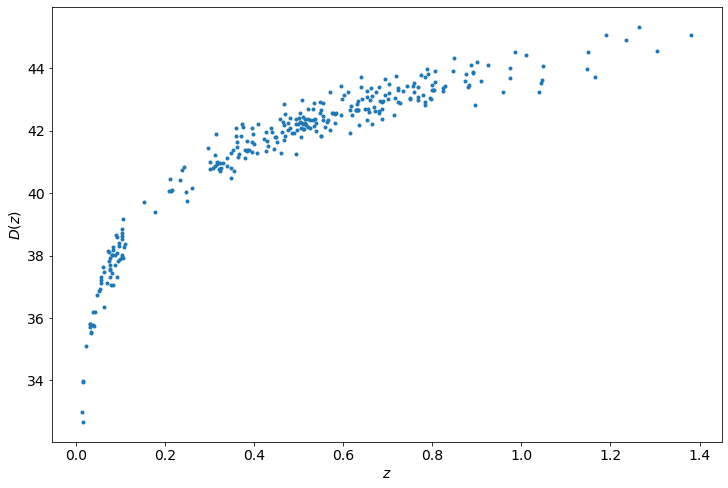

In [9]:
# Load supernovae Ia data
z, apmag_dat = np.loadtxt("SNe_simulated.txt",unpack="True")
mu_dat = apmag_dat + 19.3

# Plot distance modulus as a function of redshift
plt.figure(figsize=(12,8))
plt.plot(z, mu_dat,".")
plt.xlabel(r"$z$")
plt.ylabel(r"$D(z)$")
#plt.savefig("Plot_SNIa.pdf",  bbox_inches='tight')

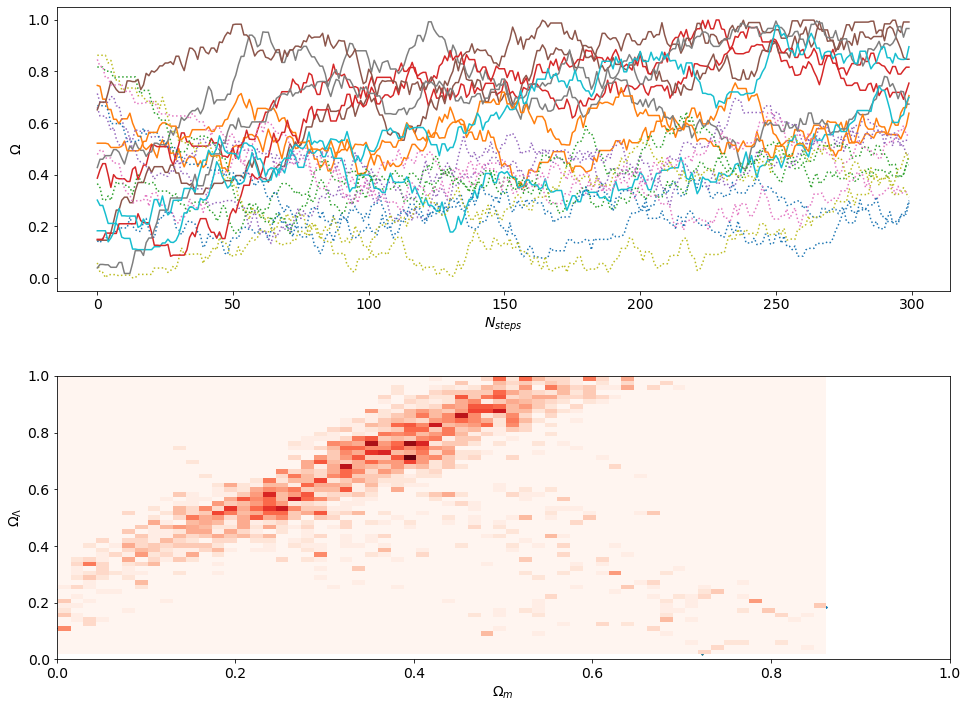

In [12]:
# Metropolis-Hastings algorithm

Om_points = []
Ol_points = []

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,12))
fig.subplots_adjust(hspace=0.3)

for chain in range(N_chains):

    Om0 = np.random.rand()*Om_max
    Ol0 = np.random.rand()*Ol_max

    Om_array = []
    Ol_array = []
    steparray = []

    for step in range(N_steps):
        
        Om1 = Om0 + np.random.uniform(-1,1)*O_step
        Ol1 = Ol0 + np.random.uniform(-1,1)*O_step
        
        Lik0 = 1.
        Lik1 = 1.
        
        for i in range(len(z)):
            
            DisTheo0 = LumDist(z[i],Om0,Ol0)
            DisTheo1 = LumDist(z[i],Om1,Ol1)
            mu0 = DistMod(DisTheo0)
            mu1 = DistMod(DisTheo1)
            Lik0 *= Gaussian(mu_dat[i]-mu0,sigma)
            Lik1 *= Gaussian(mu_dat[i]-mu1,sigma)
        
        if Om0<0 or Ol0<0: Lik0 = 0.
        if Om1<0 or Ol1<0: Lik1 = 0.
        if Om0>1. or Ol0>1.: Lik0 = 0.
        if Om1>1. or Ol1>1.: Lik1 = 0.
        
        if Lik0==0.: alfa = 1.
        else:   alfa = np.minimum(Lik1/Lik0,1.)
        
        u = np.random.uniform(0,1)
        
        if u<alfa:
            Om0 = Om1
            Ol0 = Ol1

        Om_array.append(Om0)
        Ol_array.append(Ol0)
        steparray.append(step)

    for x in Om_array: Om_points.append(x)
    for x in Ol_array: Ol_points.append(x)
    ax1.plot(steparray,Om_array,":",label=r"$\Omega_m$")
    ax1.plot(steparray,Ol_array,"-",label=r"$\Omega_\Lambda$")
    ax2.scatter(Om_array,Ol_array,s = 0.5)

ax2.scatter(Om_points,Ol_points,s = 0.5)
ax2.hist2d(Om_points,Ol_points, bins=(60, 60), cmap=plt.cm.Reds)
ax1.set_ylabel(r"$\Omega$")
ax1.set_xlabel(r"$N_{steps}$")
ax2.set_xlabel(r"$\Omega_m$")
ax2.set_ylabel(r"$\Omega_{\Lambda}$")
ax2.set_xlim([0.,Om_max])
ax2.set_ylim([0.,Ol_max])
plt.savefig("Plot_SNIa_MCMC.png",  bbox_inches='tight')
#plt.show()